# In this notebook we compare different graph classes that exhibit similar traditional graph features such as node distributions.

In the first experiment..

In [31]:
# Fun some setup for the project
# Silence annoying pytorch deprecated warnings
import warnings
warnings.filterwarnings("ignore")

from train import *
from create_graphs import *
%matplotlib inline

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print ('CUDA Available:', torch.cuda.is_available())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CUDA Available: True


In [3]:
# Generate the model datasets (i.e. the dataset used to train
# the model - normal data)
args_layer_tree, train_layer_tree, val_layer_tree, test_layer_tree = get_graph_data("layer-tree_10", isModelDataset=True)
# Save the max_previous node to allow for model 
# compatability on future datasets
max_prev_node = args_layer_tree.max_prev_node

Average num nodes 60.0
total graph num: 1000
max number node: 60
max/min number edge: 180; 180
max previous node: 31


In [4]:
# Initialize the dataset and dataloader for analyzing the nlls. 
# Note that we use batch_size = 1 because we want the nll for each
# data point not an average across a batch.
# We should also consider using Graph_sequence_Sampler_pytorch_nll.
# This sampler expands the size of the dataset by for each graph 
# creating many different bfs permutations. The idea behind this sampler
# is to test the models permutation invariance. 

train_dataset = Graph_sequence_sampler_pytorch_rand(train_layer_tree,max_prev_node=args_layer_tree.max_prev_node,max_num_node=args_layer_tree.max_num_node)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, num_workers=args_layer_tree.num_workers)

test_dataset = Graph_sequence_sampler_pytorch_rand(test_layer_tree, max_prev_node=args_layer_tree.max_prev_node,max_num_node=args_layer_tree.max_num_node)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, num_workers=args_layer_tree.num_workers)



In [5]:
# Model initialization
# Using GraphRNN

rnn = GRU_plain(input_size=args_layer_tree.max_prev_node, embedding_size=args_layer_tree.embedding_size_rnn,
                        hidden_size=args_layer_tree.hidden_size_rnn, num_layers=args_layer_tree.num_layers, has_input=True,
                        has_output=True, output_size=args_layer_tree.hidden_size_rnn_output).to(device)
output = GRU_plain(input_size=1, embedding_size=args_layer_tree.embedding_size_rnn_output,
                        hidden_size=args_layer_tree.hidden_size_rnn_output, num_layers=args_layer_tree.num_layers, has_input=True,
                        has_output=True, output_size=1).to(device)

In [7]:
# Let's do some analysis on the training data
nlls, avg_nlls = calc_nll(args_layer_tree, train_loader, rnn, output, max_iter=5,log=1)


./model_save/GraphRNN_RNN_layer-tree_10_4_128_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 1
Average Nll over train data: 243.19091472625732
Iteration: 2
Average Nll over train data: 243.65307096481322
Iteration: 3
Average Nll over train data: 243.15359088897705
Iteration: 4
Average Nll over train data: 243.28969552993775
Iteration: 5
Average Nll over train data: 243.68578729629516


In [8]:
nlls_iter = np.array(nlls)
nlls_iter = nlls_iter.reshape((5, len(train_loader)))
nlls_iter = np.mean(nlls_iter, axis=0)

In [9]:
avg_nlls_iter = np.array(avg_nlls)
avg_nlls_iter = avg_nlls_iter.reshape((5, len(train_loader)))
avg_nlls_iter = np.mean(avg_nlls_iter, axis=0)

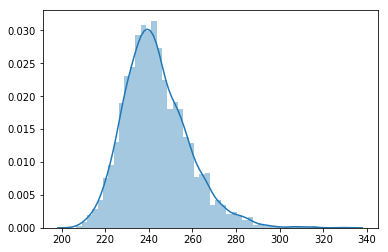

In [10]:
# Plot un averaged nlls (over the feature dimensions of the graph sequence) for the model's training dataset
plt.figure()
#ax = plt.axis()
#ax.set_xlim([0.5,1.5])
hist = sns.distplot(nlls,kde=True)

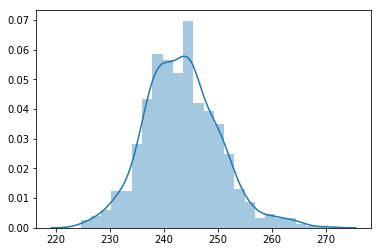

In [11]:
# Average the likelihoods across the iterations for each graph
plt.figure()
sns.distplot(nlls_iter,kde=True)

In [12]:
# Analysis of the test data set nlls.
test_nlls, test_avg_nlls = calc_nll(args_layer_tree, test_loader, rnn, output, max_iter=5, log=1)

./model_save/GraphRNN_RNN_layer-tree_10_4_128_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 1
Average Nll over train data: 242.62247787475587
Iteration: 2
Average Nll over train data: 243.85434532165527
Iteration: 3
Average Nll over train data: 242.45150672912598
Iteration: 4
Average Nll over train data: 244.55969367980958
Iteration: 5
Average Nll over train data: 243.34683311462402


In [13]:
test_nlls_iter = np.array(test_nlls)
test_nlls_iter = test_nlls_iter.reshape((5, len(test_loader)))
test_nlls_iter = np.mean(test_nlls_iter, axis=0)

In [14]:
test_avg_nlls_iter = np.array(test_avg_nlls)
test_avg_nlls_iter = test_avg_nlls_iter.reshape((5, len(test_loader)))
test_avg_nlls_iter = np.mean(test_avg_nlls_iter, axis=0)

Text(0.5,1,'NLL summed across features')

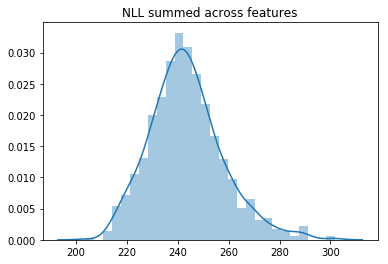

In [15]:
# Un-averaged nlls over the test normal distribution
plt.figure()
sns.distplot(test_nlls, kde=True)
plt.title('NLL summed across features')

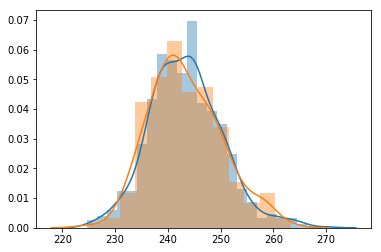

In [16]:
fig, ax = plt.subplots()
for a in [nlls_iter, test_nlls_iter]:
    sns.distplot(a, ax=ax, kde=True)

In [17]:
# Now let's try using a different dataset on the same GraphRNN
# trained on the enzyemes small dataset. By plotting the distribution
# over the nlls of this test set from a different family, hopefully
# we can see the success of the generative model
args_rand, graphs_rand = get_graph_data("random_6_60", isModelDataset=False)

# Create dataset and dataloader object for the out of distribution ladder dataset
# Note that instead of passing in args.max_prev_node, we pass in the saved max_prev_node
# saved specifically for the enzyme dataset - hack to allow for GraphRNN to work on any dataset
rand_dataset = Graph_sequence_sampler_pytorch_rand(graphs_rand,max_prev_node=max_prev_node,max_num_node=args_rand.max_num_node)
rand_loader = torch.utils.data.DataLoader(rand_dataset, batch_size=1, num_workers=args_rand.num_workers)

Average num nodes 60.0
total graph num: 3000
max number node: 60
max/min number edge: 180; 180
max previous node: None


In [18]:
# Let's see how the nlls of the ladder graphs compare to 
# the trained on enzymes.
# Note we pass in the args_enzy because the model we are
# using are trained in the enzyme dataset
rand_nlls, rand_avg_nlls = calc_nll(args_layer_tree, rand_loader, rnn, output, max_iter=5, train_dataset="layer-tree_10", log=1)


./model_save/GraphRNN_RNN_layer-tree_10_4_128_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 1
Average Nll over train data: 1534.2991068318686
Iteration: 2
Average Nll over train data: 1533.143583943685
Iteration: 3
Average Nll over train data: 1532.6683118489584
Iteration: 4
Average Nll over train data: 1527.4334559529623
Iteration: 5
Average Nll over train data: 1530.576280924479


In [19]:
rand_nlls_iter = np.array(rand_nlls)
rand_nlls_iter = rand_nlls_iter.reshape((5, len(rand_loader)))
rand_nlls_iter = np.mean(rand_nlls_iter, axis=0)

In [20]:
rand_avg_nlls_iter = np.array(rand_avg_nlls)
rand_avg_nlls_iter = rand_avg_nlls_iter.reshape((5, len(rand_loader)))
rand_avg_nlls_iter = np.mean(rand_avg_nlls_iter, axis=0)

Text(0.5,1,'NLL summed over the features')

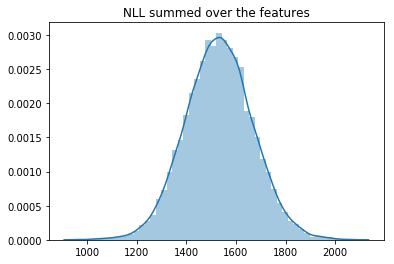

In [21]:
# Un-averaged nlls over the ladder normal distribution
plt.figure()
hist = sns.distplot(rand_nlls, kde=True)
plt.title("NLL summed over the features")

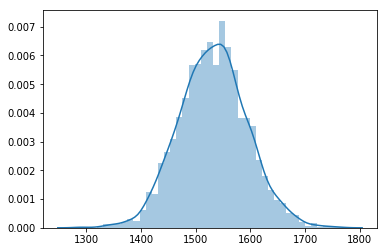

In [22]:
# Average the likelihoods across the iterations for each graph
plt.figure()
sns.distplot(rand_nlls_iter,kde=True)

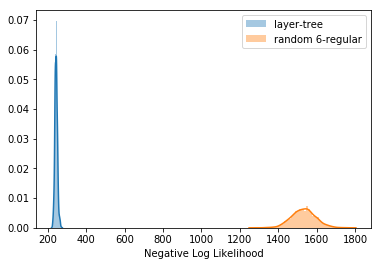

In [23]:
fig, ax = plt.subplots()
labels = ["layer-tree", "random 6-regular"]
likelihoods = [nlls_iter, rand_nlls_iter]
for i in range(len(labels)):
    sns.distplot(likelihoods[i], ax=ax, kde=True, label=labels[i])
ax.set_xlabel("Negative Log Likelihood")
ax.legend()

# Lets test the ability to generalize / have a sense of the sensativity of the model

In [24]:
# Testing on 20 layer 'layer-tree' 
# Starting with enzyme with label 2
args_tall_tree, graphs_tall_tree = get_graph_data("layer-tree_20", isModelDataset=False)

# Create dataset and dataloader object for the out of distribution ladder dataset
# Note that instead of passing in args.max_prev_node, we pass in the saved max_prev_node
# saved specifically for the enzyme dataset - hack to allow for GraphRNN to work on any dataset
tall_tree_dataset = Graph_sequence_sampler_pytorch_rand(graphs_tall_tree,max_prev_node=max_prev_node,max_num_node=args_tall_tree.max_num_node)
tall_tree_loader = torch.utils.data.DataLoader(tall_tree_dataset, batch_size=1, num_workers=args_tall_tree.num_workers)

# Let's see how the nlls of the ladder graphs compare to 
# the trained on enzymes.
# Note we pass in the args_enzy because the model we are
# using are trained in the enzyme dataset
tall_tree_nlls, tall_tree_avg_nlls = calc_nll(args_tall_tree, tall_tree_loader, rnn, output, max_iter=5, train_dataset="layer-tree_10", log=1)

tall_tree_avg_nlls_iter = np.array(tall_tree_avg_nlls)
tall_tree_avg_nlls_iter = tall_tree_avg_nlls_iter.reshape((5, len(tall_tree_loader)))
tall_tree_avg_nlls_iter = np.mean(tall_tree_avg_nlls_iter, axis=0)

Average num nodes 120.0
total graph num: 1000
max number node: 120
max/min number edge: 360; 360
max previous node: 31
./model_save/GraphRNN_RNN_layer-tree_10_4_128_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 1
Average Nll over train data: 1895.2999715576173
Iteration: 2
Average Nll over train data: 1894.537932006836
Iteration: 3
Average Nll over train data: 1907.2057662353516
Iteration: 4
Average Nll over train data: 1892.5071506347656
Iteration: 5
Average Nll over train data: 1886.8086701660156


Text(0.5,1,'Comparison of Layer-Tree with 20 layers to 10 Layers and Random (avg nll over iteration)')

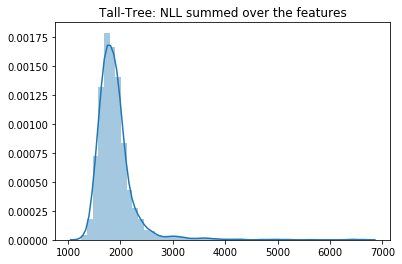

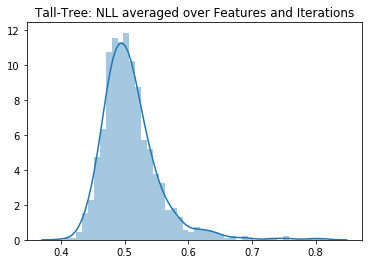

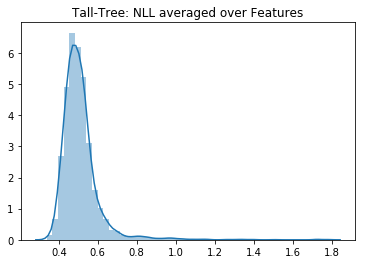

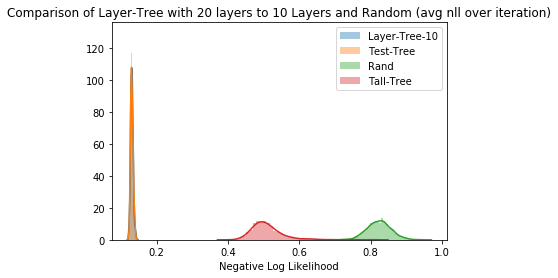

In [25]:
# Un-averaged nlls over the ladder normal distribution
plt.figure()
hist = sns.distplot(tall_tree_nlls, kde=True)
plt.title("Tall-Tree: NLL summed over the features")

# Average the likelihoods across the iterations for each graph
plt.figure()
sns.distplot(tall_tree_avg_nlls_iter,kde=True)
plt.title("Tall-Tree: NLL averaged over Features and Iterations")

# Average the likelihoods across the iterations for each graph
plt.figure()
sns.distplot(tall_tree_avg_nlls,kde=True)
plt.title("Tall-Tree: NLL averaged over Features")

fig, ax = plt.subplots()
labels = ["Layer-Tree-10", "Test-Tree", "Rand", "Tall-Tree"]
likelihoods = [avg_nlls_iter, test_avg_nlls_iter, rand_avg_nlls_iter ,tall_tree_avg_nlls_iter]
for i in range(len(labels)):
    sns.distplot(likelihoods[i], ax=ax, kde=True, label=labels[i])
ax.set_xlabel("Negative Log Likelihood")
ax.legend()
plt.title('Comparison of Layer-Tree with 20 layers to 10 Layers and Random (avg nll over iteration)')

## Now we are going to try an oversized random graph

In [26]:
# Testing on 20 layer 'layer-tree' 
# Starting with enzyme with label 2
args_rand_large, graphs_rand_large = get_graph_data("random_6_120", isModelDataset=False)

# Create dataset and dataloader object for the out of distribution ladder dataset
# Note that instead of passing in args.max_prev_node, we pass in the saved max_prev_node
# saved specifically for the enzyme dataset - hack to allow for GraphRNN to work on any dataset
rand_large_dataset = Graph_sequence_sampler_pytorch_rand(graphs_rand_large,max_prev_node=max_prev_node,max_num_node=args_rand_large.max_num_node)
rand_large_loader = torch.utils.data.DataLoader(rand_large_dataset, batch_size=1, num_workers=args_rand_large.num_workers)

# Let's see how the nlls of the ladder graphs compare to 
# the trained on enzymes.
# Note we pass in the args_enzy because the model we are
# using are trained in the enzyme dataset
rand_large_nlls, rand_large_avg_nlls = calc_nll(args_rand_large, rand_large_loader, rnn, output, max_iter=5, train_dataset="layer-tree_10", log=1)

rand_large_avg_nlls_iter = np.array(rand_large_avg_nlls)
rand_large_avg_nlls_iter = rand_large_avg_nlls_iter.reshape((5, len(rand_large_loader)))
rand_large_avg_nlls_iter = np.mean(rand_large_avg_nlls_iter, axis=0)


Average num nodes 120.0
total graph num: 3000
max number node: 120
max/min number edge: 360; 360
max previous node: None
./model_save/GraphRNN_RNN_layer-tree_10_4_128_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 1
Average Nll over train data: 3962.7638828125
Iteration: 2
Average Nll over train data: 3946.2458748372396
Iteration: 3
Average Nll over train data: 3946.2076594238283
Iteration: 4
Average Nll over train data: 3948.9109580078125
Iteration: 5
Average Nll over train data: 3951.161217610677


Text(0.5,1,'Sensativity to number of nodes')

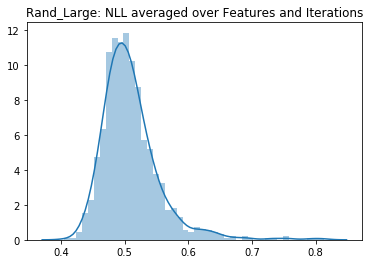

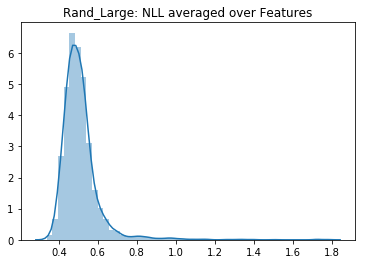

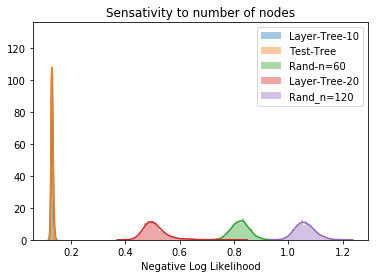

In [27]:
# Average the likelihoods across the iterations for each graph
plt.figure()
sns.distplot(tall_tree_avg_nlls_iter,kde=True)
plt.title("Rand_Large: NLL averaged over Features and Iterations")

# Average the likelihoods across the iterations for each graph
plt.figure()
sns.distplot(tall_tree_avg_nlls,kde=True)
plt.title("Rand_Large: NLL averaged over Features")

fig, ax = plt.subplots()
labels = ["Layer-Tree-10", "Test-Tree", "Rand-n=60", "Layer-Tree-20", "Rand_n=120"]
likelihoods = [avg_nlls_iter, test_avg_nlls_iter, rand_avg_nlls_iter ,tall_tree_avg_nlls_iter, rand_large_avg_nlls_iter]
for i in range(len(labels)):
    sns.distplot(likelihoods[i], ax=ax, kde=True, label=labels[i])
ax.set_xlabel("Negative Log Likelihood")
ax.legend()
plt.title('Sensativity to number of nodes')


## Lets compare to a different ladder type graph with a slightly different node distribution, but very similar

In [28]:
# Testing on 20 layer 'layer-tree' 
# Starting with enzyme with label 2
args_ladder_extra, graphs_ladder_extra = get_graph_data("ladder_extra", isModelDataset=False)

# Create dataset and dataloader object for the out of distribution ladder dataset
# Note that instead of passing in args.max_prev_node, we pass in the saved max_prev_node
# saved specifically for the enzyme dataset - hack to allow for GraphRNN to work on any dataset
ladder_extra_dataset = Graph_sequence_sampler_pytorch_rand(graphs_ladder_extra,max_prev_node=max_prev_node,max_num_node=args_ladder_extra.max_num_node)
ladder_extra_loader = torch.utils.data.DataLoader(ladder_extra_dataset, batch_size=1, num_workers=args_ladder_extra.num_workers)

# Let's see how the nlls of the ladder graphs compare to 
# the trained on enzymes.
# Note we pass in the args_enzy because the model we are
# using are trained in the enzyme dataset
ladder_extra_nlls, ladder_extra_avg_nlls = calc_nll(args_ladder_extra, ladder_extra_loader, rnn, output, max_iter=10, train_dataset="layer-tree_10", log=1)

ladder_extra_avg_nlls_iter = np.array(ladder_extra_avg_nlls)
ladder_extra_avg_nlls_iter = ladder_extra_avg_nlls_iter.reshape((10, len(ladder_extra_loader)))
ladder_extra_avg_nlls_iter = np.mean(ladder_extra_avg_nlls_iter, axis=0)

60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
6

60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
Average num nodes 60.0
total graph num: 3000
max number node: 60
max/min number edge: 158; 158
max previous node: 28
./model_save/GraphRNN_RNN_layer-tree_10_4_128_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 1
Average Nll over train data: 1144.4743270060221
Iteration: 2
Average Nll over train data: 1147.4402676595053
Iteration: 3
Average Nll over train data: 1146.0425111694335
Iteration: 4
Average Nll over train data: 1146.4214759521485
Iteration: 5
Average Nll over train data: 1146.1425944010416
Iteration: 6
Average Nll over train data: 1145.545402750651
Iteration: 7
Average Nll over train data: 1144.4976933390299
Iteration: 8
Average Nll over train data: 1145.1665225016277
Iteration: 9
Average Nll over train data: 1147.7

Text(0.5,1,'Random vs. Structred for Same Node Degree')

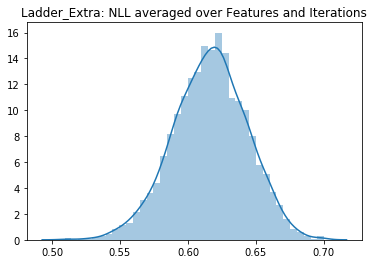

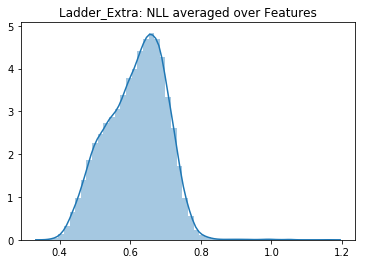

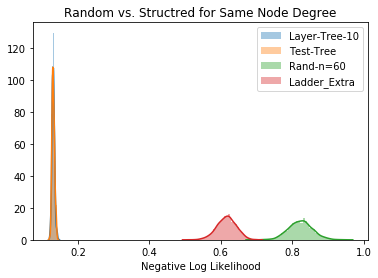

In [36]:
# Average the likelihoods across the iterations for each graph
plt.figure()
sns.distplot(ladder_extra_avg_nlls_iter,kde=True)
plt.title("Ladder_Extra: NLL averaged over Features and Iterations")

# Average the likelihoods across the iterations for each graph
plt.figure()
sns.distplot(ladder_extra_avg_nlls,kde=True)
plt.title("Ladder_Extra: NLL averaged over Features")

fig, ax = plt.subplots()
labels = ["Layer-Tree-10", "Test-Tree", "Rand-n=60", "Ladder_Extra"]
likelihoods = [avg_nlls_iter, test_avg_nlls_iter, rand_avg_nlls_iter , ladder_extra_avg_nlls_iter]
for i in range(len(labels)):
    sns.distplot(likelihoods[i], ax=ax, kde=True, label=labels[i])
ax.set_xlabel("Negative Log Likelihood")
ax.legend()
plt.title('Random vs. Structred for Same Node Degree')


In [35]:
# Testing on 20 layer 'layer-tree' 
# Starting with enzyme with label 2
args_ladder_tree, graphs_ladder_tree = get_graph_data("ladder_tree_10", isModelDataset=False)

# Create dataset and dataloader object for the out of distribution ladder dataset
# Note that instead of passing in args.max_prev_node, we pass in the saved max_prev_node
# saved specifically for the enzyme dataset - hack to allow for GraphRNN to work on any dataset
ladder_tree_dataset = Graph_sequence_sampler_pytorch_rand(graphs_ladder_tree,max_prev_node=max_prev_node,max_num_node=args_ladder_tree.max_num_node)
ladder_tree_loader = torch.utils.data.DataLoader(ladder_tree_dataset, batch_size=1, num_workers=args_ladder_tree.num_workers)

# Let's see how the nlls of the ladder graphs compare to 
# the trained on enzymes.
# Note we pass in the args_enzy because the model we are
# using are trained in the enzyme dataset
ladder_tree_nlls, ladder_tree_avg_nlls = calc_nll(args_ladder_tree, ladder_tree_loader, rnn, output, max_iter=10, train_dataset="layer-tree_10", log=1)

ladder_tree_avg_nlls_iter = np.array(ladder_tree_avg_nlls)
ladder_tree_avg_nlls_iter = ladder_tree_avg_nlls_iter.reshape((10, len(ladder_tree_loader)))
ladder_tree_avg_nlls_iter = np.mean(ladder_tree_avg_nlls_iter, axis=0)


Average num nodes 60.0
total graph num: 1000
max number node: 60
max/min number edge: 180; 180
max previous node: 28
./model_save/GraphRNN_RNN_layer-tree_10_4_128_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 1
Average Nll over train data: 969.4330719604492
Iteration: 2
Average Nll over train data: 966.7518361206055
Iteration: 3
Average Nll over train data: 964.8721925048828
Iteration: 4
Average Nll over train data: 968.7480383300781
Iteration: 5
Average Nll over train data: 972.0173153076172
Iteration: 6
Average Nll over train data: 967.7885462036132
Iteration: 7
Average Nll over train data: 973.7978618164062
Iteration: 8
Average Nll over train data: 966.607489440918
Iteration: 9
Average Nll over train data: 969.0644681396484
Iteration: 10
Average Nll over train data: 968.6407218017578


Text(0.5,1,'Random vs. Structred for Same Node Degree')

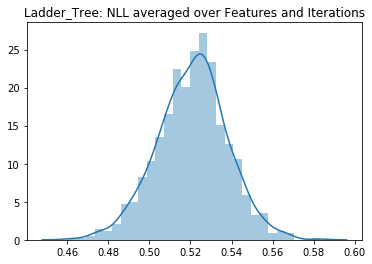

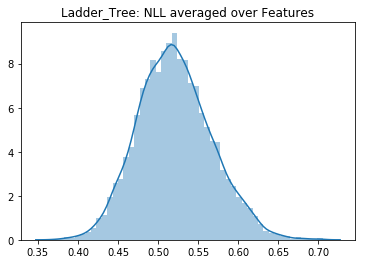

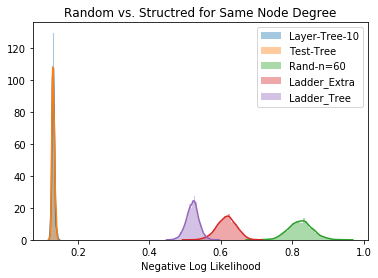

In [37]:
# Average the likelihoods across the iterations for each graph
plt.figure()
sns.distplot(ladder_tree_avg_nlls_iter,kde=True)
plt.title("Ladder_Tree: NLL averaged over Features and Iterations")

# Average the likelihoods across the iterations for each graph
plt.figure()
sns.distplot(ladder_tree_avg_nlls,kde=True)
plt.title("Ladder_Tree: NLL averaged over Features")

fig, ax = plt.subplots()
labels = ["Layer-Tree-10", "Test-Tree", "Rand-n=60", "Ladder_Extra", "Ladder_Tree"]
likelihoods = [avg_nlls_iter, test_avg_nlls_iter, rand_avg_nlls_iter , ladder_extra_avg_nlls_iter, ladder_tree_avg_nlls_iter]
for i in range(len(labels)):
    sns.distplot(likelihoods[i], ax=ax, kde=True, label=labels[i])
ax.set_xlabel("Negative Log Likelihood")
ax.legend()
plt.title('Random vs. Structred for Same Node Degree')
